# P300 with Extra Electrode

I was interested in whether the results of the P300 cats and dogs experiment could be improved by adding an extra electrode over the occipital lobe. With a dry, hair-penetrating electrode roughly placed around Oz and kept in place by a wool hat, I collected the following data. - DM

Stimulus were presented for 200ms at an interval of 600ms with a random jitter of +- 100ms.

I recorded 4 runs of 2 minutes

In [2]:
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append('../muse_lsl/muse')
import utils

%matplotlib inline

## Read data and convert them in MNE objects

Data is read from this folder's data/visual/P300 folder. Data will come from folders with the model `subject {subject}` and `session {session}`

Data is saved in csv file for more convenience. Then we will convert them into MNE data object so we can pre-process and epoch them

In [3]:
subject = 7
session = 1
raw = utils.load_data('visual/P300', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3, 4], 
                      replace_ch_names={'Right AUX': 'Oz'})

Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.


## Power Spectrum

Effective window size : 8.000 (s)


/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


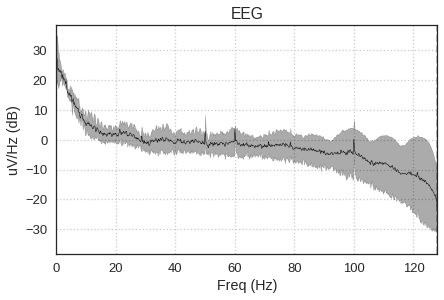

In [4]:
raw.plot_psd(tmax=np.inf);

Looks alright. We can see the 60hz peak pretty clearly.

## Filtering

We filter data between 1 and 30 Hz

In [5]:
raw.filter(1,30, method='iir')

Setting up band-pass filter from 1 - 30 Hz


<RawArray  |  None, n_channels x n_times : 6 x 122928 (480.2 sec), ~5.6 MB, data loaded>

## Epoching

Here we epoch data for -100ms to 800ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs where the signal exceed 100uV. This concerns mainly blinks.


In [6]:
from mne import Epochs, find_events

#TODO: print sample drop %
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}

epochs = Epochs(raw, events=events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, verbose=False, picks=[0,4,2,3], add_eeg_ref=False)
epochs.ch_names

780 events found
Events id: [1 2]


['TP9', 'Oz', 'AF8', 'TP10']

## Epoch average

Now we can plot the average ERP for both conditions, and see if there is something

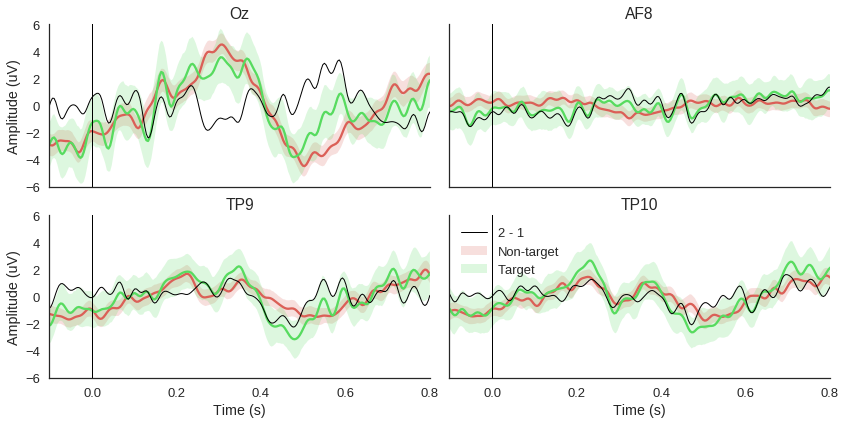

In [7]:
conditions = OrderedDict()
conditions['Non-target'] = [1]
conditions['Target'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

I'm not exactly sure what to make of this. Clearly, there's a strong pattern of positive deflections around 150, 250, and 350ms at POz, TP9, and Tp10. There's a slightly greater deflection around 350ms for the target stimuli but in the positive direction rather than the negative direction as would make sense based on Muse's refernce position.

## Decoding

Let's try the decoding pipelines to get a better sense of signal to noise ratio

Here we will use 4 different pipelines :
- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered as the standard decoding pipeline in MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very utilized in P300 BCI. It can outperform the previous one but can become unusable if the number of dimension is too high.
- **Xdawn + RegLDA** :  Xdawn spatial filtering + Vectorization of the trial + Regularized LDA.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of my favorite Riemannian geometry based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done in cross-validation, with AUC as metric (AUC is probably the best metric for binary and unbalanced classification problem)

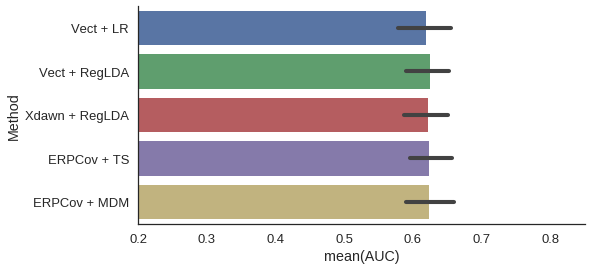

In [100]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

All pipelines are the same and the mean AUC is ~.62. I'd say that's not great

# Conclusion

Based on this initial results, I think I'll have to try this again. I might want to try and change the site of the electrode (I just eyeballed it) or try the experiments when I'm less tired.